In [1]:
import math
import numpy as np

In [2]:
pointLoads = np.array([[]])           # setting a default value
pointMoments = np.array([[]])
distributeLoads = np.array([[]])
linearLoads = np.array([[]])

In [3]:
span = 15                                  # length of beam
A = 0                                      # distance of left support from left end of beam. If no hangover present there, then A = 0.
B = 15                                     # distance of right support from left end. If no hangover is there, then just make B = span.

pointLoads = np.array([[12,0,-40]])        # position(from left end), horizontal component, vertical component
#pointMoments = np.array([[17,50]])        # position, magnitude
distributeLoads = np.array([[0,5,-5],
                            [5,10,-20],
                            [10,15,-3]])   # x_start, x_end, magnitude per unit length
#linearLoads = np.array([[8,17,-10,0]])    # x_start, x_end, start_magnitude, end_magnitude

In [4]:
division = 10000                                  # Dividing span into this number of data points
delta = span / division
X = np.arange(0, span+delta, delta)
nPL = len(pointLoads[0])
nPM = len(pointMoments[0])
nUDL = len(distributeLoads[0])                    # Uniform Distributed Load
nLVL = len(linearLoads[0])                        # Linearly Varying Load

reaction = np.array([0.0, 0, 0])
shearForce = np.zeros(len(X))     # Array to store the shear force at each point in X
bendingMoment = np.zeros(len(X))  # Array to store the bending moment at each point in X




# **Reaction Calculation**



**Function to calculate reaction due to point loads**

In [5]:
def reactions_PL(n):
  p_x = pointLoads[n, 0]
  f_x = pointLoads[n, 1]
  f_y = pointLoads[n, 2]

  la_p = A - p_x              # lever arm of point load about point A
  mp = f_y * la_p             # moment generated by point load about A. Clockwise direction is taken positive

  la_Vb = B - A               # lever arm of vertical reaction at B about point A
  Vb = mp / (la_Vb)           # vertical reaction at B
  Va = -(f_y + Vb)            # By balancing vertical forces
  Ha = -f_x                   # By balancing horizontal forces
  return Va, Vb, Ha

**Cycle through all point loads and determine reactions**

In [6]:
record_PL = np.empty([0, 3])  # initialising array with 0 rows and 3 columns
if nPL>0:
  for n,p in enumerate(pointLoads):
    v_a, v_b, h_a = reactions_PL(n)
    record_PL = np.append(record_PL, [np.array([v_a, v_b, h_a])], axis = 0)

    reaction[0] += v_a
    reaction[1] += v_b
    reaction[2] += h_a

**Function to calculate reactions due to point moments**

In [7]:
def reactions_PM(n):
  m_x = pointMoments[n, 0]
  mag = pointMoments[n, 1]
  la_Vb = B - A

  Vb = mag / la_Vb
  Va = - Vb
  return Va, Vb

**Cycle through all point moments and determine reactions**

In [8]:
record_PM = np.empty([0, 2])  # initialising array with 0 rows and 2 columns
if nPM>0:
  for n,p in enumerate(pointMoments):
    V_a, V_b = reactions_PM(n)
    record_PM = np.append(record_PM, [np.array([V_a, V_b])], axis = 0)

    reaction[0] += V_a
    reaction[1] += V_b

**Function to calculate reactions due to UDLs**

In [9]:
def reactions_UDL(n):
  xStart = distributeLoads[n,0]
  xEnd = distributeLoads[n,1]
  fy = distributeLoads[n,2]

  fy_Res = fy * (xEnd - xStart)
  x_Res = xStart + 0.5 * (xEnd - xStart)

  la_p = A - x_Res                # lever arm of resultant point load about point A
  mp = fy_Res * la_p              # moment generated by resultant point load about A. Clockwise direction is taken positive

  la_Vb = B - A                   # lever arm of vertical reaction at B about point A
  Vb = mp / (la_Vb)               # vertical reaction at B
  Va = -(fy_Res + Vb)             # By balancing vertical forces

  return Va, Vb

**Cycle through all UDLs and determine reactions**

In [10]:
record_UDL = np.empty([0, 2])  # initialising array with 0 rows and 2 columns
if nUDL>0:
  for n,p in enumerate(distributeLoads):
    Va, Vb = reactions_UDL(n)
    record_UDL = np.append(record_UDL, [np.array([Va, Vb])], axis = 0)

    reaction[0] += Va
    reaction[1] += Vb

**Function to calculate reactions due to linearly varying loads**

In [11]:
def reactions_LVL(n):
  xStart = linearLoads[n,0]
  xEnd = linearLoads[n,1]
  fStart = linearLoads[n,2]
  fEnd = linearLoads[n,3]

  if abs(fStart)>0:
    f_Res = 0.5 * fStart * (xEnd - xStart)
    x_Res = xStart + ((xEnd - xStart) / 3)
  else:
    f_Res = 0.5 * fEnd * (xEnd - xStart)
    x_Res = xStart + (2/3) * (xEnd - xStart)

  la_p = A - x_Res                # lever arm of resultant point load about point A
  mp = f_Res * la_p              # moment generated by resultant point load about A. Clockwise direction is taken positive

  la_Vb = B - A                   # lever arm of vertical reaction at B about point A
  Vb = mp / (la_Vb)               # vertical reaction at B
  Va = -(f_Res + Vb)             # By balancing vertical forces

  return Va, Vb

**Cycle through all linearly varying loads and determine reactions**

In [12]:
record_LVL = np.empty([0,2])
if nLVL>0:
  for n,p in enumerate(linearLoads):
    Va, Vb = reactions_LVL(n)
    record_LVL = np.append(record_LVL, [np.array([Va, Vb])], axis = 0)

    reaction[0] += Va
    reaction[1] += Vb

# **Shear Force & Bending Moment Calculation**

**Function to calculate shear forces and bending moments due to point loads**

In [13]:
def shear_moment_PL(n):
  p_x = pointLoads[n, 0]
  f_y = pointLoads[n, 2]
  Va = record_PL[n, 0]
  Vb = record_PL[n, 1]

  Shear = np.zeros(len(X))
  Moment = np.zeros(len(X))

  for i,x in enumerate(X):
    shear = 0
    moment = 0
    if x>A:
      shear += Va
      moment -= Va * (x - A)
    if x>B:
      shear += Vb
      moment -= Vb * (x - B)
    if x>p_x:
      shear += f_y
      moment -= f_y * (x - p_x)
    Shear[i] = shear
    Moment[i] = moment

  return Shear, Moment

**Cycle through all point loads and determine shear and moment**

In [14]:
if nPL>0:
  for n,p in enumerate(pointLoads):
    shear, moment = shear_moment_PL(n)
    shearForce += shear
    bendingMoment += moment

**Function to calculate shear forces and bending moments due to point moments**

In [15]:
def shear_moment_PM(n):
  m_x = pointMoments[n, 0]
  mag = pointMoments[n, 1]
  Va = record_PM[n, 0]
  Vb = record_PM[n, 1]

  Shear = np.zeros(len(X))
  Moment = np.zeros(len(X))

  for i,x in enumerate(X):
    shear = 0
    moment = 0
    if x>A:
      shear += Va
      moment -= Va * (x - A)
    if x>B:
      shear += Vb
      moment -= Vb * (x - B)
    if x>m_x:                                       # No effect on shear
      moment -= mag

    Shear[i] = shear
    Moment[i] = moment

  return Shear, Moment

**Cycle through all point moments and determine shear and moment**

In [16]:
if nPM>0:
  for n,p in enumerate(pointMoments):
    shear, moment = shear_moment_PM(n)
    shearForce += shear
    bendingMoment += moment

**Function to calculate shear forces and bending moments due to UDLs**

In [17]:
def shear_moment_UDL(n):
  xStart = distributeLoads[n,0]
  xEnd = distributeLoads[n,1]
  fy = distributeLoads[n,2]
  Va = record_UDL[n,0]
  Vb = record_UDL[n,1]

  Shear = np.zeros(len(X))
  Moment = np.zeros(len(X))

  for i,x in enumerate(X):
    shear = 0
    moment = 0
    if x>A:
      shear += Va
      moment -= Va * (x - A)
    if x>B:
      shear += Vb
      moment -= Vb * (x - B)
    if x>xStart and x<=xEnd:                                       # No effect on shear
      shear += fy * (x - xStart)
      moment -= fy * (x - xStart) * 0.5 * (x - xStart)
    elif x>xEnd:
      shear += fy * (xEnd - xStart)
      moment -= fy * (xEnd - xStart) * (x - xStart - 0.5 * (xEnd - xStart))

    Shear[i] = shear
    Moment[i] = moment

  return Shear, Moment

**Cycle through all UDLs and determine shear and moment**

In [18]:
if nUDL>0:
  for n,p in enumerate(distributeLoads):
    shear, moment = shear_moment_UDL(n)
    shearForce += shear
    bendingMoment += moment

**Function to calculate shear forces and bending moments due to linearly varying loads**

In [19]:
def shear_moment_LVL(n):
  xStart = linearLoads[n,0]
  xEnd = linearLoads[n,1]
  fStart = linearLoads[n,2]
  fEnd = linearLoads[n,3]
  Va = record_LVL[n,0]
  Vb = record_LVL[n,1]

  Shear = np.zeros(len(X))
  Moment = np.zeros(len(X))
  for i,x in enumerate(X):
    shear = 0
    moment = 0
    if x>A:
      shear += Va
      moment -= Va * (x - A)
    if x>B:
      shear += Vb
      moment -= Vb * (x - B)
    if x>xStart and x<=xEnd:
      if abs(fStart)>0:
        x_base = (x - xStart)
        f_cut = fStart - x_base * (fStart/(xEnd - xStart))
        R1 = 0.5 * x_base * (fStart - f_cut)
        R2 = x_base * f_cut
        shear += R1 + R2
        moment -= R1 * (2/3) * x_base + R2 * (x_base / 2)
      else:
        x_base = (x - xStart)
        f_cut = x_base * (fEnd/(xEnd - xStart))
        R = 0.5 * x_base * f_cut
        shear += R
        moment -= R * (1/3) * x_base
    elif x>xEnd:
      if abs(fStart)>0:
        R = 0.5 * fStart * (xEnd - xStart)
        xr = xStart + (1/3) * (xEnd - xStart)
        shear += R
        moment -= R * (x - xr)
      else:
        R = 0.5 * fEnd * (xEnd - xStart)
        xr = xStart + (2/3) * (xEnd - xStart)
        shear += R
        moment -= R * (x - xr)

    Shear[i] = shear
    Moment[i] = moment

  return Shear, Moment

**Cycle through all linearly varying loads and determine shear and moment**

In [20]:
if nLVL>0:
  for n,p in enumerate(linearLoads):
    shear, moment = shear_moment_LVL(n)
    shearForce += shear
    bendingMoment += moment

# **Plotting & Printing**

In [21]:
print(f"The vertical reaction at A is {reaction[0]} kN")
print(f"The vertical reaction at B is {reaction[1]} kN")
print(f"The horizontal reaction at A is {reaction[2]} kN")

The vertical reaction at A is 81.33333333333333 kN
The vertical reaction at B is 98.66666666666666 kN
The horizontal reaction at A is 0.0 kN


## **Matplotlib**

In [22]:
import matplotlib.pyplot as plt

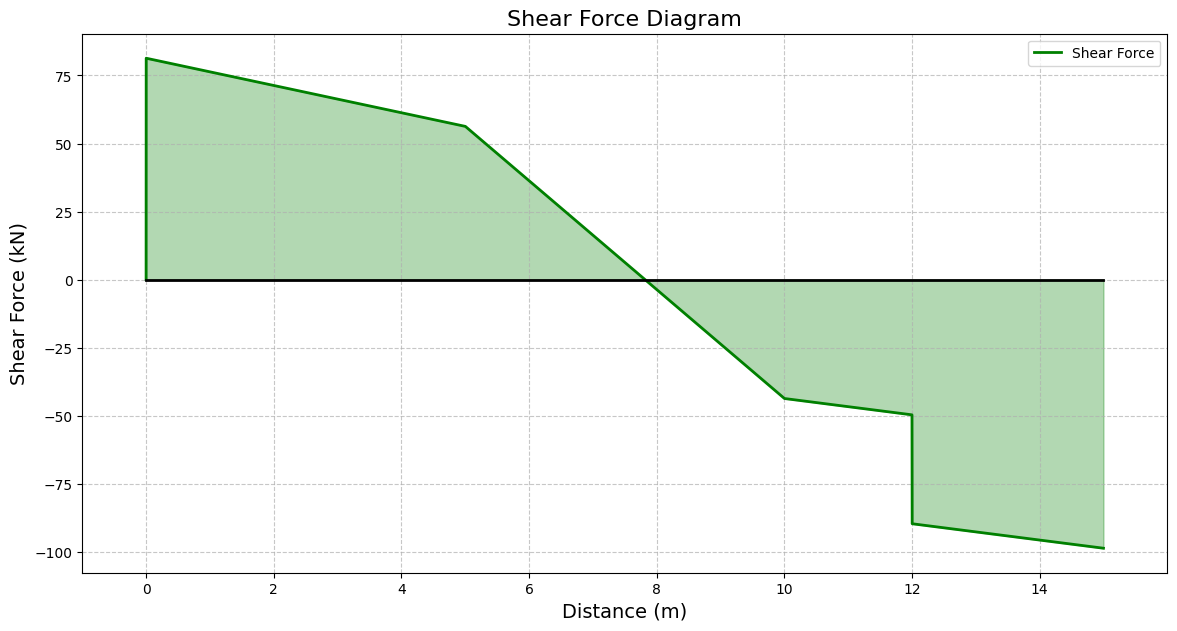

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(X, shearForce, label="Shear Force", color="green", linewidth=2)
plt.fill_between(X, shearForce, 0, color="green", alpha=0.3)
plt.plot([0, span], [0, 0], color="black", linewidth=2)

plt.title("Shear Force Diagram", fontsize=16)
plt.xlabel("Distance (m)", fontsize=14)
plt.ylabel("Shear Force (kN)", fontsize=14)

x_ticks = np.arange(0, np.max(X) + 1, 2)  # Generate values from 0 to max(X) with step of 2
plt.xticks(x_ticks)

plt.xlim(-1, np.max(X) + 1)
plt.legend()

plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

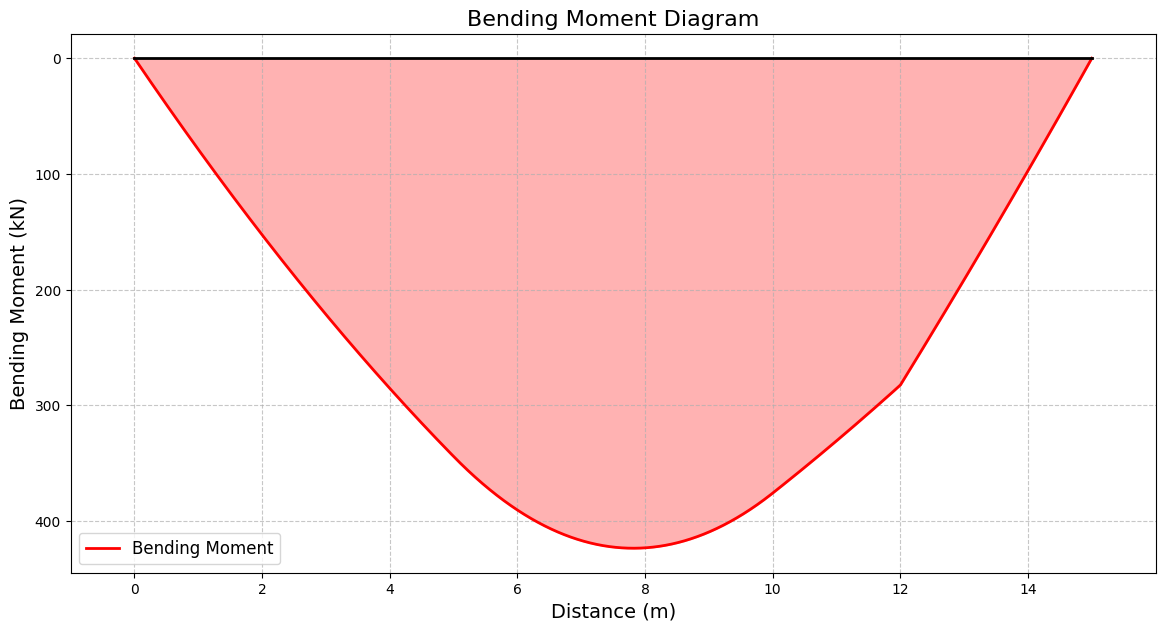

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(X, -bendingMoment, label="Bending Moment", color="red", linewidth=2)
plt.fill_between(X, -bendingMoment, 0, color="red", alpha=0.3)
plt.plot([0, span], [0, 0], color="black", linewidth=2)

# Invert y-axis
plt.gca().invert_yaxis()

plt.title("Bending Moment Diagram", fontsize=16)
plt.xlabel("Distance (m)", fontsize=14)
plt.ylabel("Bending Moment (kN)", fontsize=14)

x_ticks = np.arange(0, np.max(X) + 1, 2)  # Generate values from 0 to max(X) with step of 2
plt.xticks(x_ticks)

plt.xlim(-1, span + 1)
plt.legend(fontsize=12)

plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [41]:
def shearForce_at_distance(distance):
    index = np.searchsorted(X, distance)
    return shearForce[index]

distance = float(input(f"Enter the distance (between 0 and {span} meters) to calculate the shear force: "))
force_at_distance = shearForce_at_distance(distance)
print(f"The shear force at {distance} meters is {force_at_distance:.2f} kN")

Enter the distance (between 0 and 15 meters) to calculate the shear force: 7.8157
The shear force at 7.8157 meters is 0.00 kN


In [42]:
def bending_moment_at_distance(distance):
    index = np.searchsorted(X, distance)
    return bendingMoment[index]

distance = float(input(f"Enter the distance (between 0 and {span} meters) to calculate the bending moment: "))
moment_at_distance = bending_moment_at_distance(distance)
print(f"The bending moment at {distance} meters is {moment_at_distance:.2f} kNm")

Enter the distance (between 0 and 15 meters) to calculate the bending moment: 8
The bending moment at 8.0 meters is -423.16 kNm
